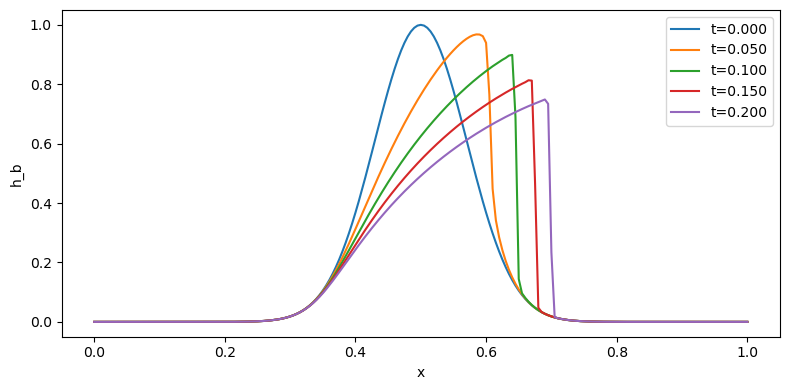

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

# ————————————————
# 参数定义
# ————————————————
L      = 1.0        # 域长度
nx     = 201        # 网格点数
dx     = L/(nx-1)
x      = np.linspace(0, L, nx)

H0     = 1.0        # H(x) 的标度
rho_w  = 1000.      # 水密度 kg/m^3
g      = 9.81       # 重力加速度 m/s^2
mu_eff = 1e3        # 有效粘度 Pa·s
k      = rho_w * g / (12 * mu_eff)

# 正则化 H'(x)，避免奇异
eps = 1e-6
Hp = -H0/(2*L) * (1 - x/L + eps)**(-0.5)

# 初始条件：高斯脊
h0 = np.exp(-((x - 0.5*L)/(0.1*L))**2)

# WENO5 重构导数函数
def weno5_flux_derivative(f):
    eps_w = 1e-6
    # extend ghost cells by zero-gradient
    fg = np.zeros(len(f) + 4)
    fg[2:-2] = f
    fg[:2]  = f[0]
    fg[-2:] = f[-1]
    # compute left-biased flux at interfaces
    def compute_flux(arr):
        f0, f1, f2, f3, f4 = arr
        p0 = (2*f0 - 7*f1 + 11*f2) / 6
        p1 = (-f1 + 5*f2 + 2*f3) / 6
        p2 = (2*f2 + 5*f3 - f4) / 6
        β0 = 13/12*(f0 - 2*f1 + f2)**2 + 1/4*(f0 - 4*f1 + 3*f2)**2
        β1 = 13/12*(f1 - 2*f2 + f3)**2 + 1/4*(f1 - f3)**2
        β2 = 13/12*(f2 - 2*f3 + f4)**2 + 1/4*(3*f2 - 4*f3 + f4)**2
        α0 = 0.1    / (eps_w + β0)**2
        α1 = 0.6    / (eps_w + β1)**2
        α2 = 0.3    / (eps_w + β2)**2
        αsum = α0 + α1 + α2
        w0, w1, w2 = α0/αsum, α1/αsum, α2/αsum
        return w0*p0 + w1*p1 + w2*p2
    # reconstruct interface fluxes
    fL = np.array([compute_flux(fg[i:i+5]) for i in range(len(fg)-4)])
    # compute derivative at centers, pad zero at left boundary
    dfdx_int = (fL[1:] - fL[:-1]) / dx  # length nx-1
    dfdx = np.zeros_like(f)
    dfdx[1:] = dfdx_int
    return dfdx

# 右侧算子
def rhs(h):
    F = k * h**3 * Hp
    return weno5_flux_derivative(F)

# 时间积分：TVD RK3
dt    = 1e-4
t_max = 0.2
nt    = int(t_max/dt)
times = [0, t_max/4, t_max/2, 3*t_max/4, t_max]

# 记录
h = h0.copy()
h_record = {t: h.copy() if t==0 else None for t in times}

for n in range(1, nt+1):
    k1 = rhs(h)
    h1 = h + dt * k1
    k2 = rhs(h1)
    h2 = 3/4*h + 1/4*(h1 + dt*k2)
    k3 = rhs(h2)
    h = 1/3*h + 2/3*(h2 + dt*k3)

    t = n*dt
    for tp in times:
        if abs(t-tp) < dt/2:
            h_record[tp] = h.copy()

# 绘图
plt.figure(figsize=(8,4))
for tp in sorted(h_record.keys()):
    plt.plot(x, h_record[tp], label=f't={tp:.3f}')
plt.xlabel('x')
plt.ylabel('h_b')
plt.legend()
plt.tight_layout()
plt.show()


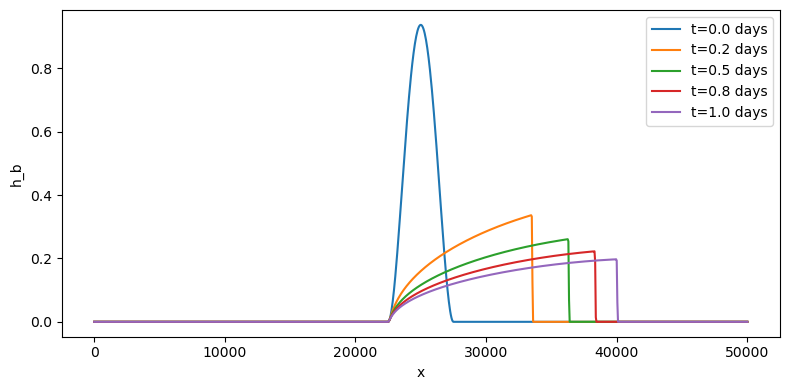

In [ ]:
# Dimensional simulation of a glacier hydrology model using WENO5 reconstruction for flux derivatives.
# This code simulates the evolution of water thickness in a glacier hydrology system over time,
# using a WENO5 scheme for accurate flux calculations. The model parameters and initial conditions
# are defined, and the simulation runs for a specified duration, recording the state at various time points.
# Finally, it visualizes the results using matplotlib.
# This code is a Python adaptation of a glacier hydrology model

import numpy as np
import matplotlib.pyplot as plt

# ————————————————
# Dimensional parameters
# ————————————————
L      = 5e4        # domain length in meters
nx     = 1001        # number of grid points
dx     = L/(nx-1)   # grid spacing
x      = np.linspace(0, L, nx)

H0     = 1e3        # H at x=0 in meters
rho_w  = 1000.      # water density in kg/m^3
g      = 9.81       # gravitational acceleration in m/s^2
mu_eff = 1e1        # effective viscosity in Pa·s
k      = rho_w * g / (12 * mu_eff)

# time integration: TVD RK3
td   =  24*3600          # one day in seconds
t_max = 1.0*td          # maximum time in seconds
dt    = t_max / 5000   # time step in seconds
nt    = int(t_max/dt)
times = [0, t_max/4, t_max/2, 3*t_max/4, t_max]

# Scales
# l0 = 1e3  # length scale in meters
# t0 = 1e2  # time scale in seconds

# regularize H'(x) to avoid singularities
eps = 1e-14
Hp = -H0/(2*L) * (1 - x/L + eps)**(-0.5)

# initial condition: Gaussian ridge
Vl = 2.5e3  # initial volume in m^3
R = 2.5e3  # initial radius in meters
h0 = (np.abs(x-0.5*L)<R)*(15*Vl/(16*R))*(1-((x - 0.5*L)/R)**2)**2

# WENO5 reconstruction derivative function
def weno5_flux_derivative(f):
    eps_w = 1e-6
    # extend ghost cells by zero-gradient
    fg = np.zeros(len(f) + 4)
    fg[2:-2] = f
    fg[:2]  = f[0]
    fg[-2:] = f[-1]
    # compute left-biased flux at interfaces
    def compute_flux(arr):
        f0, f1, f2, f3, f4 = arr
        p0 = (2*f0 - 7*f1 + 11*f2) / 6
        p1 = (-f1 + 5*f2 + 2*f3) / 6
        p2 = (2*f2 + 5*f3 - f4) / 6
        b0 = 13/12*(f0 - 2*f1 + f2)**2 + 1/4*(f0 - 4*f1 + 3*f2)**2
        b1 = 13/12*(f1 - 2*f2 + f3)**2 + 1/4*(f1 - f3)**2
        b2 = 13/12*(f2 - 2*f3 + f4)**2 + 1/4*(3*f2 - 4*f3 + f4)**2
        a0 = 0.1    / (eps_w + b0)**2
        a1 = 0.6    / (eps_w + b1)**2
        a2 = 0.3    / (eps_w + b2)**2
        asum = a0 + a1 + a2
        w0, w1, w2 = a0/asum, a1/asum, a2/asum
        return w0*p0 + w1*p1 + w2*p2
    # reconstruct interface fluxes
    fL = np.array([compute_flux(fg[i:i+5]) for i in range(len(fg)-4)])
    # compute derivative at centers, pad zero at left boundary
    dfdx_int = (fL[1:] - fL[:-1]) / dx  # length nx-1
    dfdx = np.zeros_like(f)
    dfdx[1:] = dfdx_int
    return dfdx

# flux function
def rhs(h):
    F = k * h**3 * Hp
    return weno5_flux_derivative(F)

# 记录
h = h0.copy()
h_record = {t: h.copy() if t==0 else None for t in times}

for n in range(1, nt+1):
    k1 = rhs(h)
    h1 = h + dt * k1
    k2 = rhs(h1)
    h2 = 3/4*h + 1/4*(h1 + dt*k2)
    k3 = rhs(h2)
    h = 1/3*h + 2/3*(h2 + dt*k3)

    t = n*dt
    for tp in times:
        if abs(t-tp) < dt/2:
            h_record[tp] = h.copy()

# 绘图
plt.figure(figsize=(8,4))
for tp in sorted(h_record.keys()):
    plt.plot(x, h_record[tp], label=f't={tp/td:.1f} days')
plt.xlabel('x')
plt.ylabel('h_b')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Dimensionless simulation of a glacier hydrology model using WENO5 reconstruction for flux derivatives.

import numpy as np
import matplotlib.pyplot as plt

# ————————————————
# Dimensional parameters
# ————————————————
L      = 5e4        # domain length in meters
H0     = 1e3        # H at x=0 in meters
rho_w  = 1000.      # water density in kg/m^3
rho_i  = 917.0      # ice density in kg/m^3
g      = 9.81       # gravitational acceleration in m/s^2
mu_eff = 1e1        # effective viscosity in Pa·s
k      = rho_i * g / (12 * mu_eff)

# Scales and dimensionless parameters
l0 = 1e3  # length scale in meters
t0 = 1e2  # time scale in seconds
h0 = 1.0
D = h0**2*t0*(rho_i*g*H0)/(12 * mu_eff*l0**2)

# ————————————————
# Dimensionless parameters
# ————————————————
#  Grid
nx     = 1001        # number of grid points
dx     = L/(nx-1)   # grid spacing
x      = np.linspace(0, L, nx)

# Dimensionless time integration: TVD RK3
dt    = t_max / 5000 # time step in seconds
nt    = int(t_max/dt)
times = [0, t_max/4, t_max/2, 3*t_max/4, t_max]

# regularize H'(x) to avoid singularities
eps = 1e-14
Hp = -H0/(2*L) * (1 - x/L + eps)**(-0.5)

# initial condition: Gaussian ridge
Vl = 2.5e3  # initial volume in m^3
R = 2.5e3  # initial radius in meters
h0 = (np.abs(x-0.5*L)<R)*(15*Vl/(16*R))*(1-((x - 0.5*L)/R)**2)**2

# WENO5 reconstruction derivative function
def weno5_flux_derivative(f):
    eps_w = 1e-6
    # extend ghost cells by zero-gradient
    fg = np.zeros(len(f) + 4)
    fg[2:-2] = f
    fg[:2]  = f[0]
    fg[-2:] = f[-1]
    # compute left-biased flux at interfaces
    def compute_flux(arr):
        f0, f1, f2, f3, f4 = arr
        p0 = (2*f0 - 7*f1 + 11*f2) / 6
        p1 = (-f1 + 5*f2 + 2*f3) / 6
        p2 = (2*f2 + 5*f3 - f4) / 6
        b0 = 13/12*(f0 - 2*f1 + f2)**2 + 1/4*(f0 - 4*f1 + 3*f2)**2
        b1 = 13/12*(f1 - 2*f2 + f3)**2 + 1/4*(f1 - f3)**2
        b2 = 13/12*(f2 - 2*f3 + f4)**2 + 1/4*(3*f2 - 4*f3 + f4)**2
        a0 = 0.1    / (eps_w + b0)**2
        a1 = 0.6    / (eps_w + b1)**2
        a2 = 0.3    / (eps_w + b2)**2
        asum = a0 + a1 + a2
        w0, w1, w2 = a0/asum, a1/asum, a2/asum
        return w0*p0 + w1*p1 + w2*p2
    # reconstruct interface fluxes
    fL = np.array([compute_flux(fg[i:i+5]) for i in range(len(fg)-4)])
    # compute derivative at centers, pad zero at left boundary
    dfdx_int = (fL[1:] - fL[:-1]) / dx  # length nx-1
    dfdx = np.zeros_like(f)
    dfdx[1:] = dfdx_int
    return dfdx

# flux function
def rhs(h):
    F = k * h**3 * Hp
    return weno5_flux_derivative(F)

# 记录
h = h0.copy()
h_record = {t: h.copy() if t==0 else None for t in times}

for n in range(1, nt+1):
    k1 = rhs(h)
    h1 = h + dt * k1
    k2 = rhs(h1)
    h2 = 3/4*h + 1/4*(h1 + dt*k2)
    k3 = rhs(h2)
    h = 1/3*h + 2/3*(h2 + dt*k3)

    t = n*dt
    for tp in times:
        if abs(t-tp) < dt/2:
            h_record[tp] = h.copy()

# 绘图
plt.figure(figsize=(8,4))
for tp in sorted(h_record.keys()):
    plt.plot(x, h_record[tp], label=f't={tp/td:.1f} days')
plt.xlabel('x')
plt.ylabel('h_b')
plt.legend()
plt.tight_layout()
plt.show()
